# Searching for Structure in Point Data

This lecture concerns itself with methods for exploring and quantifying structure in a multivariate distribution of points (multidimensional points). One name for this kind of activity is *exploratory data analysis* (EDA). Given a sample of $N$ points in $D$-dimensional space, there are three classes of problems that are frequently encountered in practice: density estimation, cluster finding, and statistical description of the observed structure. The space populated by points in the sample can be real physical space, or a space spanned by the measured quantities (attributes). For example, we can consider the distribution of sources in a multidimensional color space, or in a six-dimensional space spanned by three-dimensional positions and three-dimensional velocities.

To infer the pdf from a sample of data is known as density estimation. The same methodology is often called data smoothing. The simplest example of this is a histogram. Density estimation is one of the most critical components of extracting knowledge from data. For example, given a pdf estimated from point data, we can generate simulated distributions of data and compare them against observations. If we can identify regions of low probability within the pdf, we have a mechanism for the detection of unusual or anomalous sources. If our point data can be separated into subsamples using provided class labels, we can estimate the pdf for each subsample and use the resulting set of pdfs to classify new points: the probability that a new point belongs to each subsample/class is proportional to the pdf of each class evaluated at the position of the point. Density estimation relates directly to regression and is at the heart of many of the classification procedures.

Given a point data set, we can further ask whether it displays any structure (as opposed to a random distribution of points). Finding concentrations of multivariate points (or groups of sources) is known in astronomy as “clustering” (when a density estimate is available, clusters correspond to “overdensities”). Clusters can be defined to be distinct objects (e.g., gravitationally bound clusters of galaxies), or loose groups
of sources with common properties (e.g., the identification of quasars based on
their color properties). Unsupervised clustering refers to cases where there is no prior information about the number and properties of clusters in data. Unsupervised classification assigns to each cluster found by unsupervised
clustering, a class based on additional information (e.g., clusters identified in color space might be assigned the labels “quasar” and “star” based on supplemental spectral data). In some cases, such as when considering the distribution of sources in multidimensional color space, clusters can have specific physical meaning (e.g., hot stars, quasars, cold stars). On the other hand, in some applications, such as large-scale clustering of galaxies, clusters carry information only in a statistical sense. For example, we can test cosmological models of structure formation by comparing clustering
statistics in observed and simulated data. 

## Nonparametric Density Estimation

Here we look at how to estimate a density nonparametrically, that is, without specifying a specific functional model. Real data rarely follow simple distributions — nonparametric methods are meant to capture every aspect of the density’s shape. What we lose by taking this route is the convenience, relative computational simplicity (usually), and easy interpretability of parametric models. Nonparametric methods play a central role in modern machine learning. They provide the highest possible predictive accuracies, as they can model any shape of distribution, down to the finest detail which still has predictive power, though they typically come at a higher computational cost than more traditional multivariate statistical methods. In addition, it is harder to interpret the results of nonparametric methods than those of parametric models.

The go-to method for nonparametric density estimation, that is, modeling of the underlying distribution, is the method of *kernel density estimation*. As a model of kernel density estimation, we'll have first have a look at the one-dimensional histogram.

### Histograms

To construct a histogram, we need to specify bin boundaries, and we implicitly assume that the estimated distribution function is piecewise constant within each bin. A histogram can fit virtually any shape of distribution, given enough bins. This is the key—while each bin can be thought of as a simple constant estimator of the density in that bin, the overall histogram is a piecewise constant estimator which can be thought of as having a tuning parameter—the number of bins. When the number of data points is small, the number of bins should somehow be small, as there is not enough information to warrant many bins. As the number of data points grows, the number of bins should also grow to capture the increasing amount of detail in the distribution’s shape that having more data points allows. This is a general feature of
nonparametric methods—they are composed of simple pieces, and the number of
pieces grows with the number of data points.

Getting the number of bins right is clearly critical. Pragmatically, it can easily make the difference between concluding that a distribution has a single mode or that it has two modes. Intuitively, we expect that a large bin width will destroy finescale features in the data distribution, while a small width will result in increased counting noise per bin. It is not necessary to bin the data before estimating model parameters. A simple example is the case of data drawn from a Gaussian distribution. We can estimate its parameters µ and σ without ever binning the data. Nevertheless, binning can allow
us to visualize our data and explore various features in order to motivate the model selection.

We will now look at a few rules of thumb for the surprisingly subtle question of choosing the critical bin width. Various proposed methods for choosing optimal bin width typically suggest a value proportional to some estimate of the distribution’s scale, and decreasing with the sample size. The most popular choice is “Scott’s rule” which prescribes a bin width

$$
\begin{equation*}
\Delta_b=\frac{3.5\sigma}{N^{1/3}}
\end{equation*}
$$

where $\sigma$ is the sample standard deviation, and $N$ is the sample size. This rule asymptotically minimizes the mean integrated square error and assumes the underlying distribution is Gaussian. An attempt to generalize this rule to non-Gaussian distributions is the Freedman-Diaconis rule,

$$
\begin{equation*}
\Delta_b=\frac{2(q_{75}-q_{25})}{N^{1/3}} = \frac{2.7\sigma_G}{N^{1/3}}
\end{equation*}
$$

which estimates the scale ("spread") of the distribution from its interquartile range (a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles). In the case of a Gaussian distribution, Scott's bin width is 30% larger than the Freedman-Diaconis bin width. Although the Freedman–Diaconis rule attempts to account for non-Gaussian distributions, it is too simple to distinguish, for example, multimodal and unimodal distributions that have the same $\sigma_G$. The main reason why finding the optimal bin size is not straightforward is that the result depends on both the actual data distribution and the choice of metric (such as the mean square error) to be optimized. The interpretation of binned data essentially represents a model fit, where the model is a piecewise constant function. Different bin widths correspond to different models, and choosing the best bin width amounts to the selection of the best model.

NumPy and Matplotlib contain powerful tools for creating histograms in one or multiple dimensions:

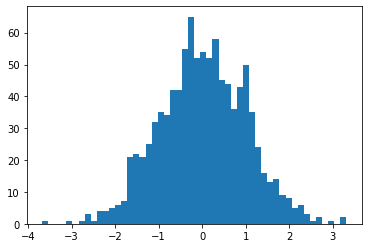

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Enable inline plotting
%matplotlib inline

# Generate 1000 points which are normally distributed
x = np.random.normal(size=1000)

# Use the matplotlib hist function to create a histogram with 50 bins
plt.hist(x, bins=50)
plt.show()

# For computing you can use the numpy.histogram, numpy.histogram2d 
# and numpy.histogramdd:
counts, bins = np.histogram(x, bins=50)

Except for choosing the number of bins, another problem with a standard histogram is the fact that the exact locations of the bins can make a difference, and yet it is not clear how to choose in advance where the bins should be placed. This is illustrated in the figure below. 

<img src="img/histogram_bin_locations.PNG" />

This shows histograms constructed with an identical data set, and with identical bin widths, but with bins offset in x by 0.25. This offset leads to very different histograms and possible interpretations of the data: the difference between seeing it as a bimodal distribution vs. an extended flat distribution.

## Kernel Density Estimation

How can we improve on a basic histogram and avoid this problem? Each point
within a histogram contributes one unit to the height of the histogram at the position of its bin. One possibility is to allow each point to have its own bin, rather than arranging the bins in a regular grid, and furthermore allow the bins to overlap. In essence, each point is replaced by a box of unit height and some predefined width. This is shown in the code snippet below. This
distribution does not require a specific choice of bin boundaries—the data drive the bin positioning—and does a much better job of showing the bimodal character of the underlying distribution than the histogram shown above (the same data is used).

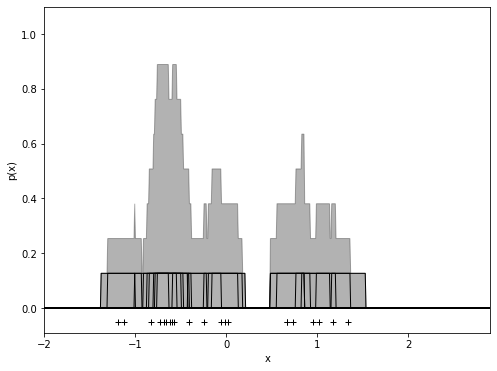

In [2]:
plt.figure(figsize=(8,6))

# Generate some random data using two Gaussians
np.random.seed(1)  # Set seed so that generated data is always the same
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14),
                    np.random.normal(1, 0.3, size=7)])

# Use same bin width as histogram image above
binwidth = 0.375

# Split the x-axis into 1000 points
x_plot = np.linspace(-4, 4, 1000)

# Each data point in x is treated as a bin. The value of these bins
# are combined to generate y_plot
y_plot = (abs(x_plot - x[:, None]) <= 0.5 * binwidth).astype(float)

# Normalise y_plot by the length of the x-axis and the binwidth
y_plot /= (binwidth * len(x))

# Plot the summed bin values by summing across the y-dimension
plt.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)

# Plot each "bin", or x value, showing its range
plt.plot(x_plot, y_plot.T, '-k', lw=1)

# Show the center of each bin (that is, its exact value) with a marker
# below the x axis line
plt.plot(x, 0 * x - 0.05, '+k')

# Beautify and show
plt.xlim((-2, 2.9))
plt.ylim((-0.09, 1.1))
plt.ylabel('p(x)')
plt.xlabel('x')
plt.show()

The above simple recipe for producing a histogram is an example of kernel
density estimation. Here the kernel is a top-hat distribution centered on each
individual point. It can be shown theoretically that this kernel density estimator
(KDE) is a better estimator of the density than the ordinary histogram.
However the rectangular kernel does not lead to a very smooth distribution and can even display suspicious
spikes. For this reason, other kernels, for example Gaussians, are often used. The snippet below generates the kernel density estimate
of the same data but now using Gaussian kernels of different widths. Using too
narrow a kernel (first plot) leads to a noisy distribution, while using
too wide a kernel (second plot) leads to excessive smoothing and washing
out of information. A well-tuned kernel (third plot) can lead to accurate
estimation of the underlying distribution.

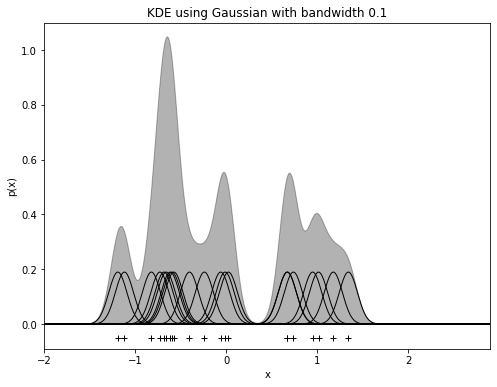

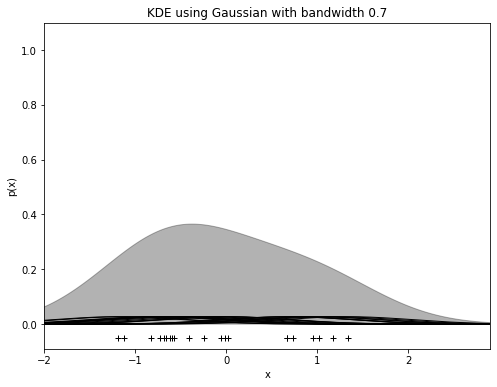

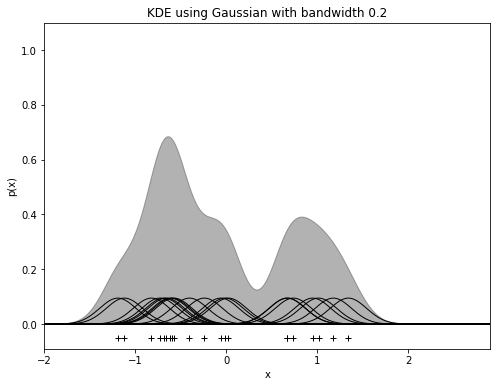

In [3]:
# This code snippet is almost the same as the above,
# the only difference being that each point is not treated
# as a top-hat but as a gaussian. The KDE and plot generation
# logic are defined as a function to make it reusable
from scipy import stats

# The bw (bandwidth) defines the width of the Gaussian kernel
def kde_gaussian(bw):
    plt.figure(figsize=(8,6))

    x_plot = np.linspace(-4, 4, 1000)

    # This is the line which differs
    y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], bw)

    y_plot /= (binwidth * len(x))
    plt.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
    plt.plot(x_plot, y_plot.T, '-k', lw=1)
    plt.plot(x, 0 * x - 0.05, '+k')
    plt.xlim((-2, 2.9))
    plt.ylim((-0.09, 1.1))
    plt.title("KDE using Gaussian with bandwidth {}".format(bw))
    plt.ylabel('p(x)')
    plt.xlabel('x')
    plt.show()

# KDEs with Gaussian of different widths
kde_gaussian(0.1)
kde_gaussian(0.7)
kde_gaussian(0.2)

Given a set of measurements $x_i$, the kernel density estimator (i.e., an estimator of the underlying pdf) at an arbitrary position $x$ is defined as

$$
\begin{equation*}
\hat{f}_N = \frac{1}{Nh^D} \sum^N_{i=1}K\left (\frac{d(x, x_i)}{h} \right )
\end{equation*}
$$

where $K(u)$ is the *kernel function* and $h$ is known as the bandwidth (which defines the size of the kernel). The local density is estimated as a weighted mean of all points, where the weights are specified via $K(u)$ and typically decreases with distance $d(x, x_i)$. Alternatively, KDE can be viewed as replacing each point with a "cloud" described by $K(u)$. The kernel funtion $K(u)$ can be any smooth function that is positive at all points ($K(u) \geq 0$), normalizes to unity ($\int K(u)\,du=1$), has a mean of zero ($\int uK(u)\,du=0$), and has a variance ($\sigma^2_K = \int u^2K(d)\,d$u) greater than zero. An often-used kernel is the Gaussian kernel,

$$
\begin{equation*}
K(u) = \frac{1}{(2\pi)^{D/2}}e^{-u^2/2}
\end{equation*}
$$

where $D$ is the number of dimensions of the parameter space and $u=d(x, x_i)/h$. Other kernels which can be used are the top-hat (box) kernel,

$$
\begin{equation*}
K(u) = 
    \begin{cases}
    \frac{1}{V_D(1)} & \text{if u $\leq$ 1}, \\ \\
    0                & \text{if u > 1}
    \end{cases}
\end{equation*}
$$

and the exponential kernel

$$
\begin{equation*}
K(u) = \frac{1}{D!\,V_D(1)}e^{-|u|}
\end{equation*}
$$

where $V_D(r)$ is the volume of a D-dimensional hypersphere of radius $r$.

### Selecting the bandwidth via cross-validation

The choice of bandwidth within KDE is extremely important to finding a suitable density estimate, and is the knob that controls the bias–variance trade-off in the estimate of density: too narrow a bandwidth leads to a high-variance estimate (over-fitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estimate (under-fitting) where the structure in the data is washed out by the wide kernel.

In machine learning contexts, such hyperparameter tuning often is done empirically via a cross-validation approach. With this in mind, the `KernelDensity` estimator in Scikit-Learn,  which is a very
fast kernel density estimator based on a KD Tree, is designed such that it can be used directly within the Scikit-Learn's standard grid search tools. Here we will use `GridSearchCV` to optimize the bandwidth for the preceding dataset. Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial:

In [4]:
# sklearn's KernelDensity module, which is a very
# fast kernel density estimator based on a KD Tree
from sklearn.neighbors import KernelDensity


from sklearn.model_selection import GridSearchCV, LeaveOneOut

bandwidths = np.linspace(0.1, 1, 10)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(),
                    error_score='raise')
grid.fit(x[:, None])

print("Best bandwidth: {}".format(grid.best_params_['bandwidth']))

Best bandwidth: 0.2


The code snippet below shows an example of KDE applied to a 2D data set: a sample of galaxies centered on the SDSS "Great Wall". The distribution of points (galaxies) is used to estimate the "smooth" underlying distribution using three types of kernels. The top-hat kernel is the most “spread out” of the kernels, and its imprint on the resulting distribution is apparent, especially in underdense regions. Between the Gaussian and exponential kernels, the exponential is more sharply peaked and has wider tails, but both recover similar features in the distribution.

(8014, 2)


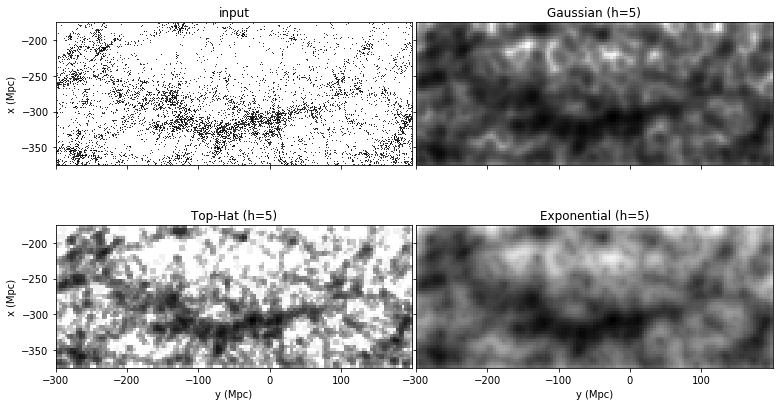

In [13]:
from matplotlib.colors import LogNorm

# Load the great wall data
X = np.load('data/sdss_great_wall.npy')

# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

# Create a grid containing the x and y axis coordinate combination
Xgrid = np.zeros((Nx * Ny, 2))
x = np.linspace(xmin, xmax, Nx)
y = np.linspace(ymin, ymax, Ny)
for i in range(Nx):
    for j in range(Ny):
        Xgrid[j * Nx + i] = [x[i], y[j]]

# Run KDE using gaussian kernel
kde1 = KernelDensity(5, kernel='gaussian')
log_dens1 = kde1.fit(X).score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

# Run KDE using tophat kernel
kde2 = KernelDensity(5, kernel='tophat')
log_dens2 = kde2.fit(X).score_samples(Xgrid)
dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

# Run KDE using exponential kernel
kde3 = KernelDensity(5, kernel='exponential')
log_dens3 = kde3.fit(X).score_samples(Xgrid)
dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

# Plot the results
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.set_title("input")

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.set_title("Gaussian (h=5)")

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.set_title("Top-Hat (h=5)")
ax3.images[0].set_clim(0.01, 0.8)  # Set color limit to avoid clipping

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.set_title("Exponential (h=5)")

# Set axis labels and limits
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('y (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('x (Mpc)')

plt.show()

### Nearest-Neighbour Density Estimation

Another often used and simple density estimation technique is based on the distribution of nearest neighbors. For each point (e.g., a pixel location on the 2D grid) we can find the distance to the Kth-nearest neighbor, $d_K$. In this method the implied point density at an arbitrary position $x$ is estimated as

$$ 
\begin{equation*}
\hat{f}_K(x) = \frac{K}{V_D(d)K)}
\end{equation*}
$$

where the volume $V_D$ is evaluated according to the problem dimensionality $D$ (e.g., for $D$ = 2, $V_2 = \pi d^2$; for $D$ = 3, $V_3=4\pi d^3/d$ ...). The simplicity of this estimator is a consequence of the assumption that the underlying density field is locally constant. This general method can be improved (errors in $\hat{f}$ can be decreased) by considering distances to *all* K nearest neighbors instead of only the distance to the K th-nearest neighbor.

The code snippet below compares density estimation using the Gaussian kernel with a bandwidth of 5 Mpc and using the nearest neighbor method with K=5 and K=40 for the same sample of galaxies as above. For small K the fine structure in the galaxy distribution is preserved but at the cost of a larger variance
in the density estimation. As K increases the density distribution becomes smoother, at the cost of additional bias in the other estimates.

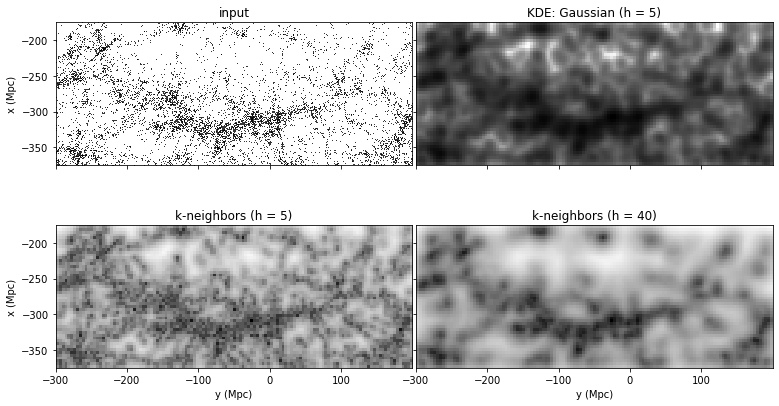

In [6]:
from astroML.density_estimation import KNeighborsDensity

# Evaluate for several models
kde = KernelDensity(5, kernel='gaussian')
dens_KDE = kde.fit(X).score_samples(Xgrid)
dens_KDE = X.shape[0] * np.exp(dens_KDE).reshape((Ny, Nx))

knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.set_title("input")

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens_KDE.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.set_title("KDE: Gaussian (h = 5)")

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.set_title("k-neighbors (h = 5)")

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.set_title("k-neighbors (h = 40)")

# Set axis labels and limits
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('y (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('x (Mpc)')

plt.show()

## Finding Cluster in Data

"Clustering" in astronomy refers to a number of different aspects of data analysis. Given a multivariate point data set, we can ask whether it displays any structure, that is, concentrations of points. Alternatively, when a density estimate is available we can search for “overdensities.” Another way to interpret clustering is to seek a
partitioning or segmentation of data into smaller parts according to some criteria.

Finding clusters is sometimes thought of as “black art” since the objective criteria for it seems more elusive than, say, for a prediction task such as classification (where we know the true underlying function for at least some subset of the sample). When we can speak of a true underlying function (as we do in most density estimation, classification, and regression methods) we mean that we have a score or error function with which to evaluate the effectiveness of our analysis. Under this model we can discuss optimization, error bounds, generalization (i.e., minimizing error on future data), what happens to the error as we get more data, etc. In other words we can leverage all the powerful tools of statistics.

### K-Means Clustering

One of the simplest methods for partitioning data into a small number of clusters is K-means. K-means seeks a partitioning of the points into K disjoint subsets $Ck$ with each subset containing $Nk$ points such that the following sum-of-squares objective function is minimized:

$$
\begin{equation*}
\sum^K_{k=1}\sum_{i \in C_k} ||x_i-\mu_k||^2
\end{equation*}
$$

where $$\mu_k = \frac{1}{N_k}\sum_{i\in C_k}x_i$$ is the mean of the points in set $C_k$, and $C(x_i)=C_k$ denotes that the class of $x_i$ is $C_k$.

The procedure for K-means is to initially choose the centroid, $\mu_k$, of each of the K clusters. We then assign each point to the cluster that is closest to (i.e. according to $C(x_i)=\text{argmin}_k ||x_i - \mu_k||$). At this point we update the centroid of each cluster by recomputing $\mu_k$ according to the new assignments. The process continues until there are no new assignments. 

The K-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the k-means model. We will soon dive into exactly how the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the k-means result.

While a globally optimal minimum cannot be guaranteed, the process can
be shown to never increase the sum-of-squares error. In practice K-means is run
multiple times with different starting values for the centroids of $Ck$ and the result with the lowest sum-of-squares error is used. K-means can be considered as a “hard” clustering algorithm, in the sense that each data point is assigned to exactly one cluster (we'll see later on that there are alternative "soft" algorithm which can assign a set of probabilities to each data point, each representing the probability of it belonging to a specific cluster).

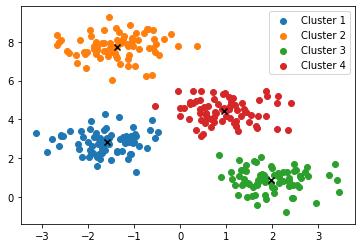

In [7]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

# Generate a two-dimensional dataset containing four distinct blobs. 
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# Run K-Means clustering with k=4, and get labels and centers
clf = KMeans(n_clusters=4)
clf.fit(X)
centers = clf.cluster_centers_
labels=clf.predict(X)

# Plot cluster
for i in range(4):
    plt.scatter(X[np.where(labels == i), 0], X[np.where(labels == i), 1], label="Cluster {}".format(i+1))

# Show cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='k')

plt.legend()
plt.show()

The K-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye. But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly. The typical approach to k-means involves an intuitive iterative approach known as expectation–maximization.

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. K-means is a particularly simple and easy-to-understand application of the algorithm. In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
    1. E-Step: assign points to the nearest cluster center
    2. M-Step: set the cluster centers to the mean
    
Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

We will discuss Expectation Maximisation in more detail in another lecutre.

#### Caveats of K-Means with E-M

##### The globally optimal result may not be acieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results. In the case below, we're providing K-Means with a set of starting center locations (all at the origin):

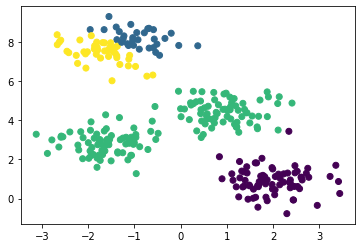

In [8]:
# Initial cluster centers
initial_centers = np.array([[0,0], [0,0], [0,0], [0,0]])
labels = KMeans(n_clusters=4, init=initial_centers, n_init=1).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the `n_init parameter`, which defaults to 10, here set to 1).

##### The number of clusters must be selected beforehand

Another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data. For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

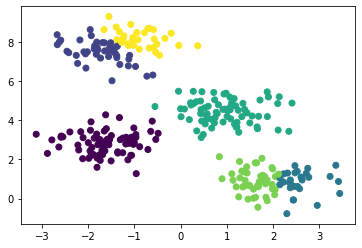

In [9]:
# Run K-Means clustering with k=6
labels = KMeans(n_clusters=6).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models, which we'll cover in another lecture) or which can choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the `sklearn.cluster` submodule)

##### K-Means is limited to linear cluster boundaries

The fundamental model assumptions of K-Means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical K-Means approach:

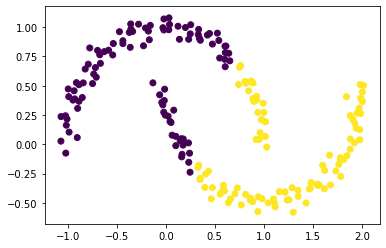

In [10]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels)

We can project the data to higher dimensions where a linear separation is possible and use k-means to discover non-linear boundaries. One version of this kernelized k-means is implemented in Scikit-Learn within the `SpectralClustering` estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a K-Means algorithm. We see that with this kernel transform approach, the kernelized k-means is able to find the more complicated nonlinear boundaries between clusters.

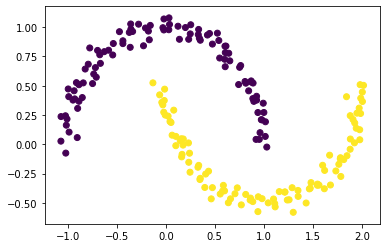

In [11]:
# Our data is not fully connected and Spectral Clustering will issue
# a warning to tell us. We'll ignore this warning
import warnings
warnings.simplefilter("ignore", UserWarning)

# Import SpectralClustering
from sklearn.cluster import SpectralClustering

# Use SpectralClustering to cluster the data
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels)

##### K-Means can be slow for large number of samples

Because each iteration of K-Means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based K-Means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`.